In [1]:
import os
import sys
import random
import argparse
import json
import numpy as np
from glob import glob
from collections import namedtuple

from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from torchvision import transforms
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from reportlab.lib.pagesizes import landscape, letter
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle
from reportlab.lib import colors

import src.network as network
import src.utils
from src.utils import ext_transforms as et
from src.metrics import StreamSegMetrics
from datasets.dataloaders import DataProcessor, KITTI360Dataset, DatasetLoader
from src.weaklabelgenerator import labelgenerator
from src.finetune_bucket import finetuner
import wandb

from IPython.display import display

import sys
import os
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils import data
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import src.network as network
from datasets.kitti_360 import KittiDatasetLoader
from datasets.cityscapes_v1 import CityscapesDatasetLoader
from src.metrics import StreamSegMetrics


In [2]:
# Defining the model paths
model_name = "deeplabv3plus_resnet101"
old_model_path = 'checkpoints/best_deeplabv3plus_resnet101_cityscapes_os16.pth'
new_model_path = 'checkpoints/ranked_2k_class_SL_full_KD_pixel.pth'

#new_model_path = 'checkpoints/latest_bucket_0_rand_deeplabv3plus_resnet101_kitti_os16.pth'

# model = network.modeling.__dict__[model_name](num_classes=19, output_stride=16)

In [3]:
# Load model
def load_model(checkpoint_path, model_name='deeplabv3plus_resnet101', num_classes=19, output_stride=16):
    model = network.modeling.__dict__[model_name](num_classes=num_classes, output_stride=output_stride)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint["model_state"])
    model = nn.DataParallel(model)
    model.to(device)
    return model

In [4]:

# Load data
def load_data(json_file, dataset_name, num_test=50):
    if dataset_name == 'cityscapes':
        dataset_loader = CityscapesDatasetLoader()
    elif dataset_name == 'kitti_360':
        dataset_loader = KittiDatasetLoader()
    else:
        raise ValueError(f"Invalid dataset: {dataset_name}")

    with open(json_file, 'r') as file:
        json_data = json.load(file)

    val_image_paths = [item.get('image') for item in json_data if item.get('image_exists')]
    val_ground_truth_paths = [item.get('ground_truth') for item in json_data if item.get('ground_truth_exists')]

    if len(val_image_paths) > num_test:
        sampled_indices = np.random.choice(len(val_image_paths), num_test, replace=False)
        val_image_paths = [val_image_paths[i] for i in sampled_indices]
        val_ground_truth_paths = [val_ground_truth_paths[i] for i in sampled_indices]
        print(f"Sampled {num_test} images from the dataset")

    val_dst = dataset_loader.get_datasets(val_image_paths, val_ground_truth_paths)
    val_loader = data.DataLoader(val_dst, batch_size=4, shuffle=True, num_workers=2)
    return val_loader, val_image_paths, val_ground_truth_paths


In [5]:
# Validate model
def validate(model, loader, device, metrics):
    metrics.reset()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(loader)):
            images = images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(images)
            preds = outputs.detach().max(dim=1)[1].cpu().numpy()
            targets = labels.cpu().numpy()
            metrics.update(targets, preds)
            all_preds.extend(preds.flatten())
            all_targets.extend(targets.flatten())
    return metrics.get_results(), all_preds, all_targets


In [6]:

# Calculate additional metrics
def calculate_additional_metrics(all_preds, all_targets, num_classes):
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_preds, average='weighted')
    cm = confusion_matrix(all_targets, all_preds, labels=range(num_classes))
    return {
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Confusion Matrix': cm
    }


In [7]:

def plot_confusion_matrix(cm, class_names, title=None, normalize=True):
    plt.figure(figsize=(12, 10))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    if title:
        plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
metrics = StreamSegMetrics(19)

Using device: cuda


In [8]:
# Load models
baseline_model = load_model(old_model_path)
finetuned_model = load_model(new_model_path)

In [9]:
# Load data
datasets = [
        ('cityscapes', 'tests/cityscapes_val_set.json'),
        ('kitti_360', 'tests/kitti-360_val_set_v3.json')
    ]

In [9]:
class_names = [
        'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light', 'traffic sign',
        'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train',
        'motorcycle', 'bicycle'
    ]


Analyzing CITYSCAPES dataset:
Sampled 50 images from the dataset


13it [01:33,  7.21s/it]


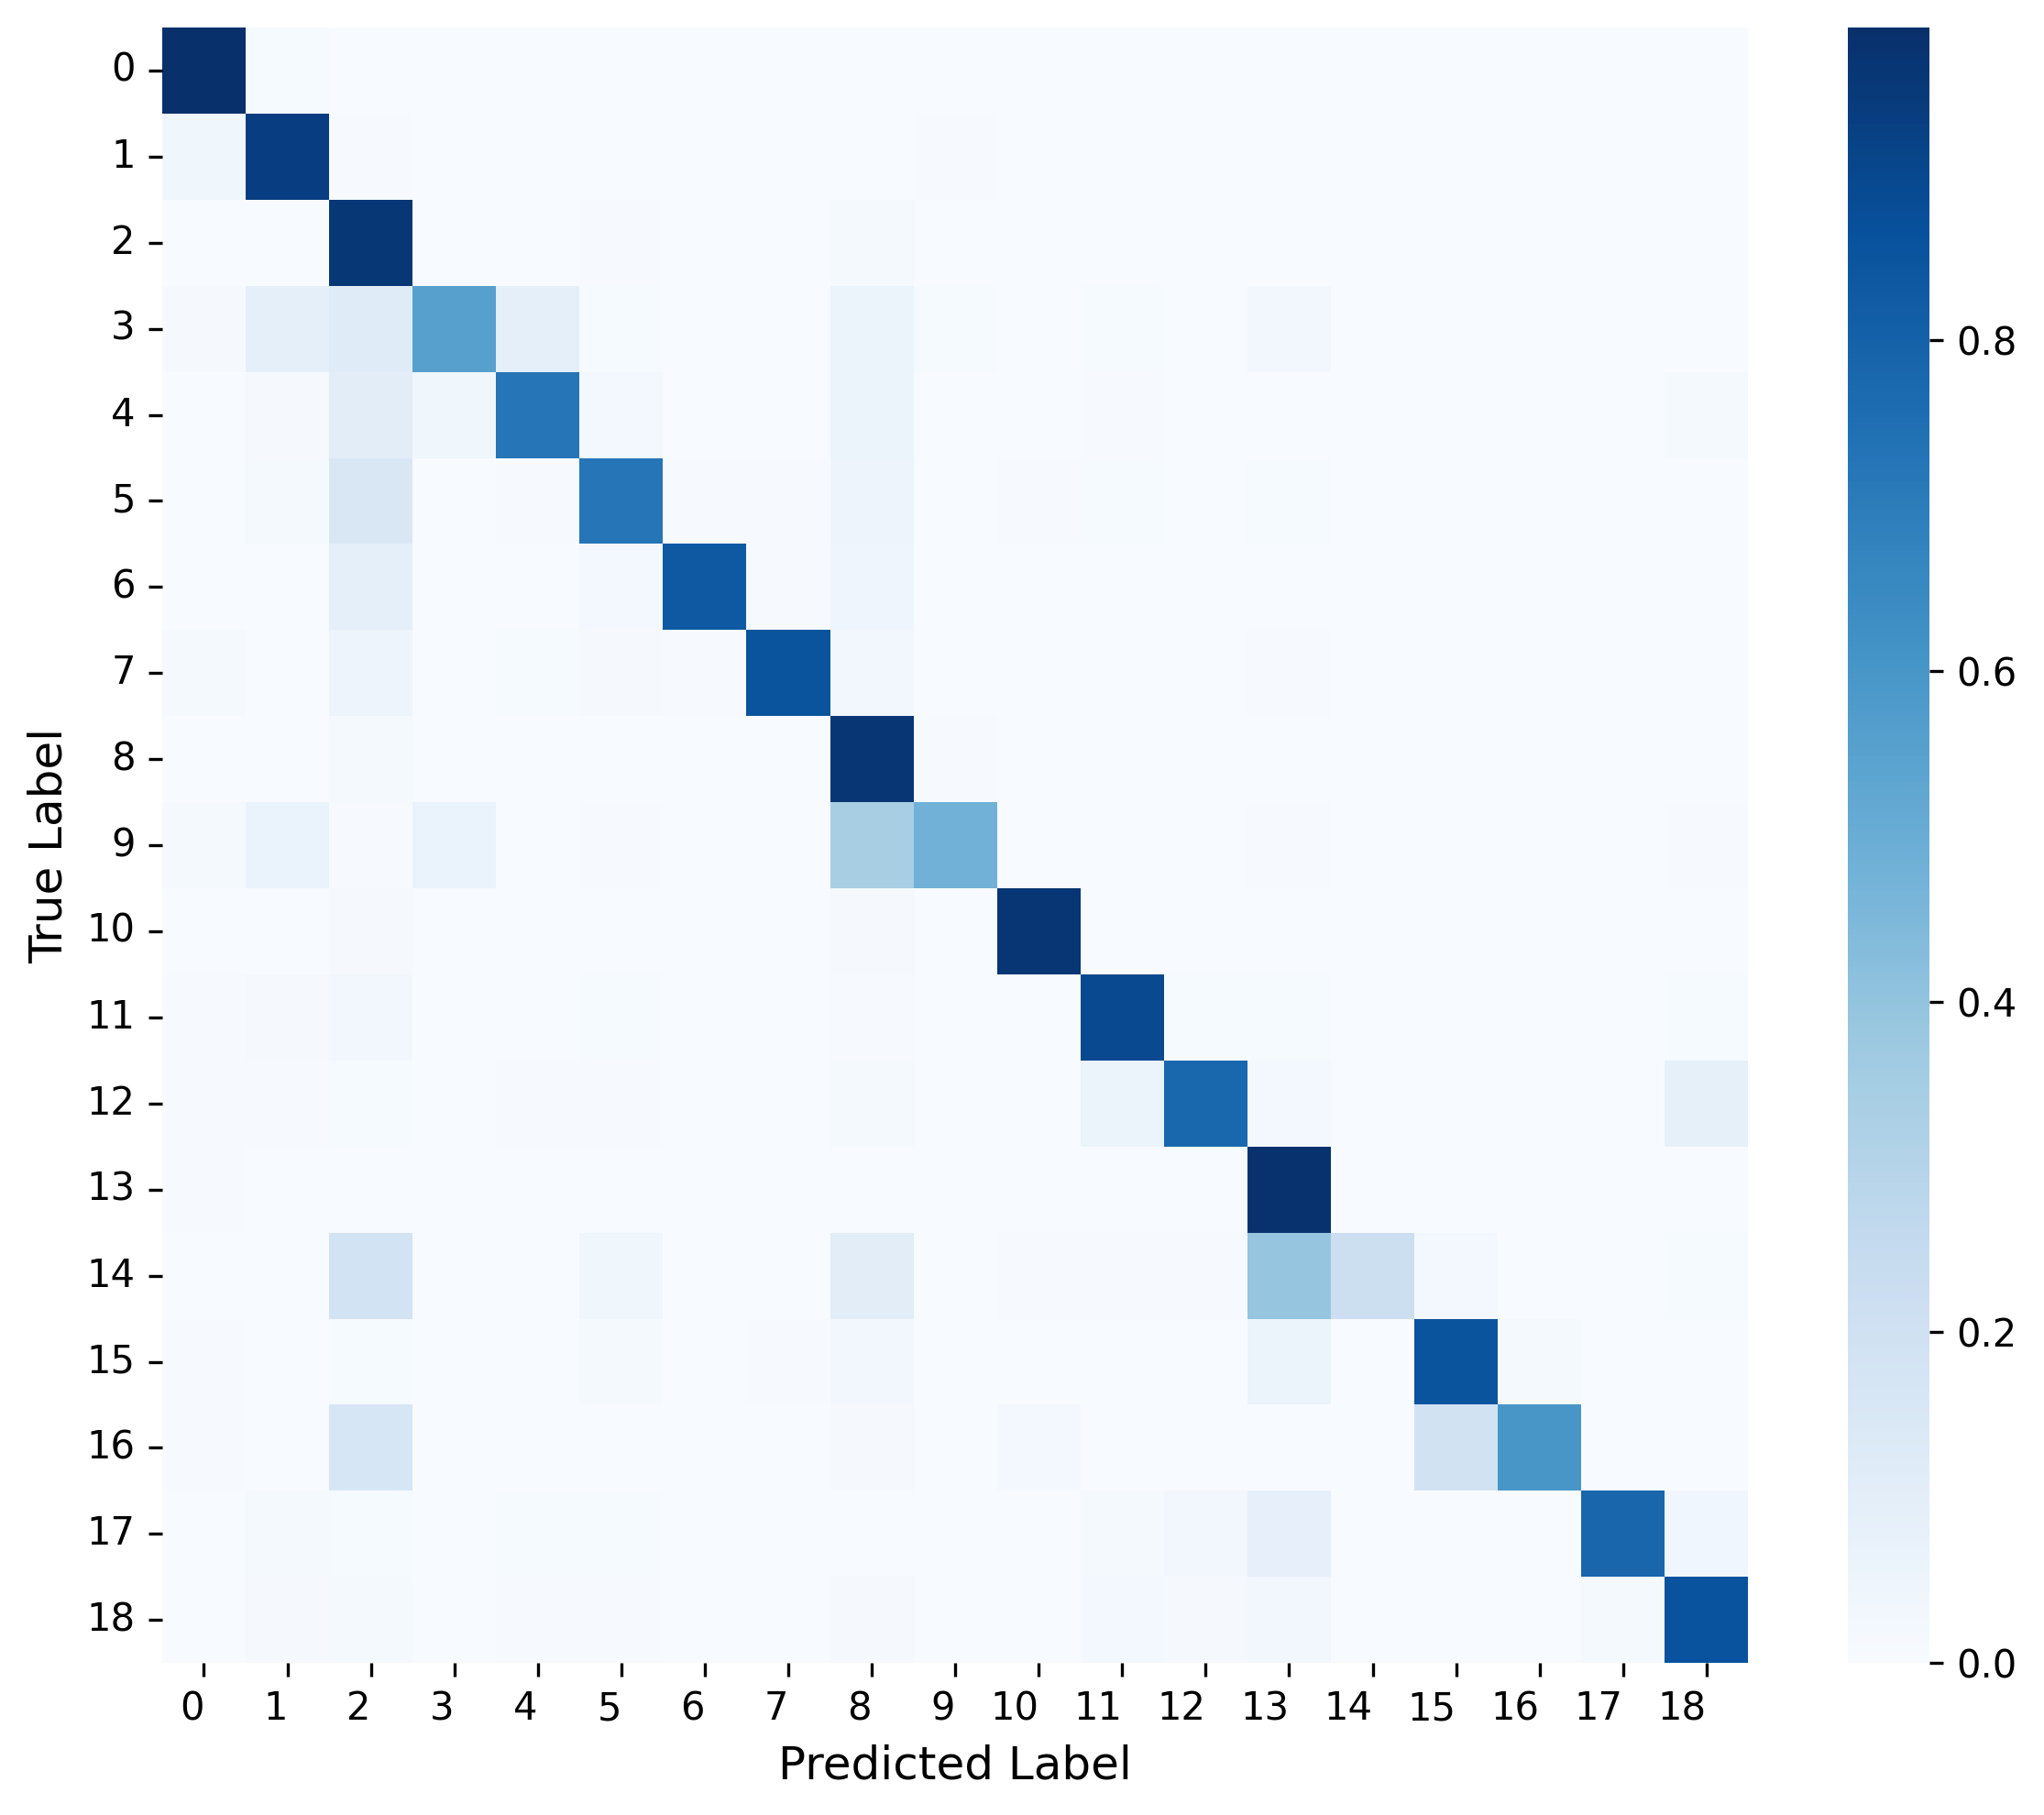

13it [01:30,  7.00s/it]


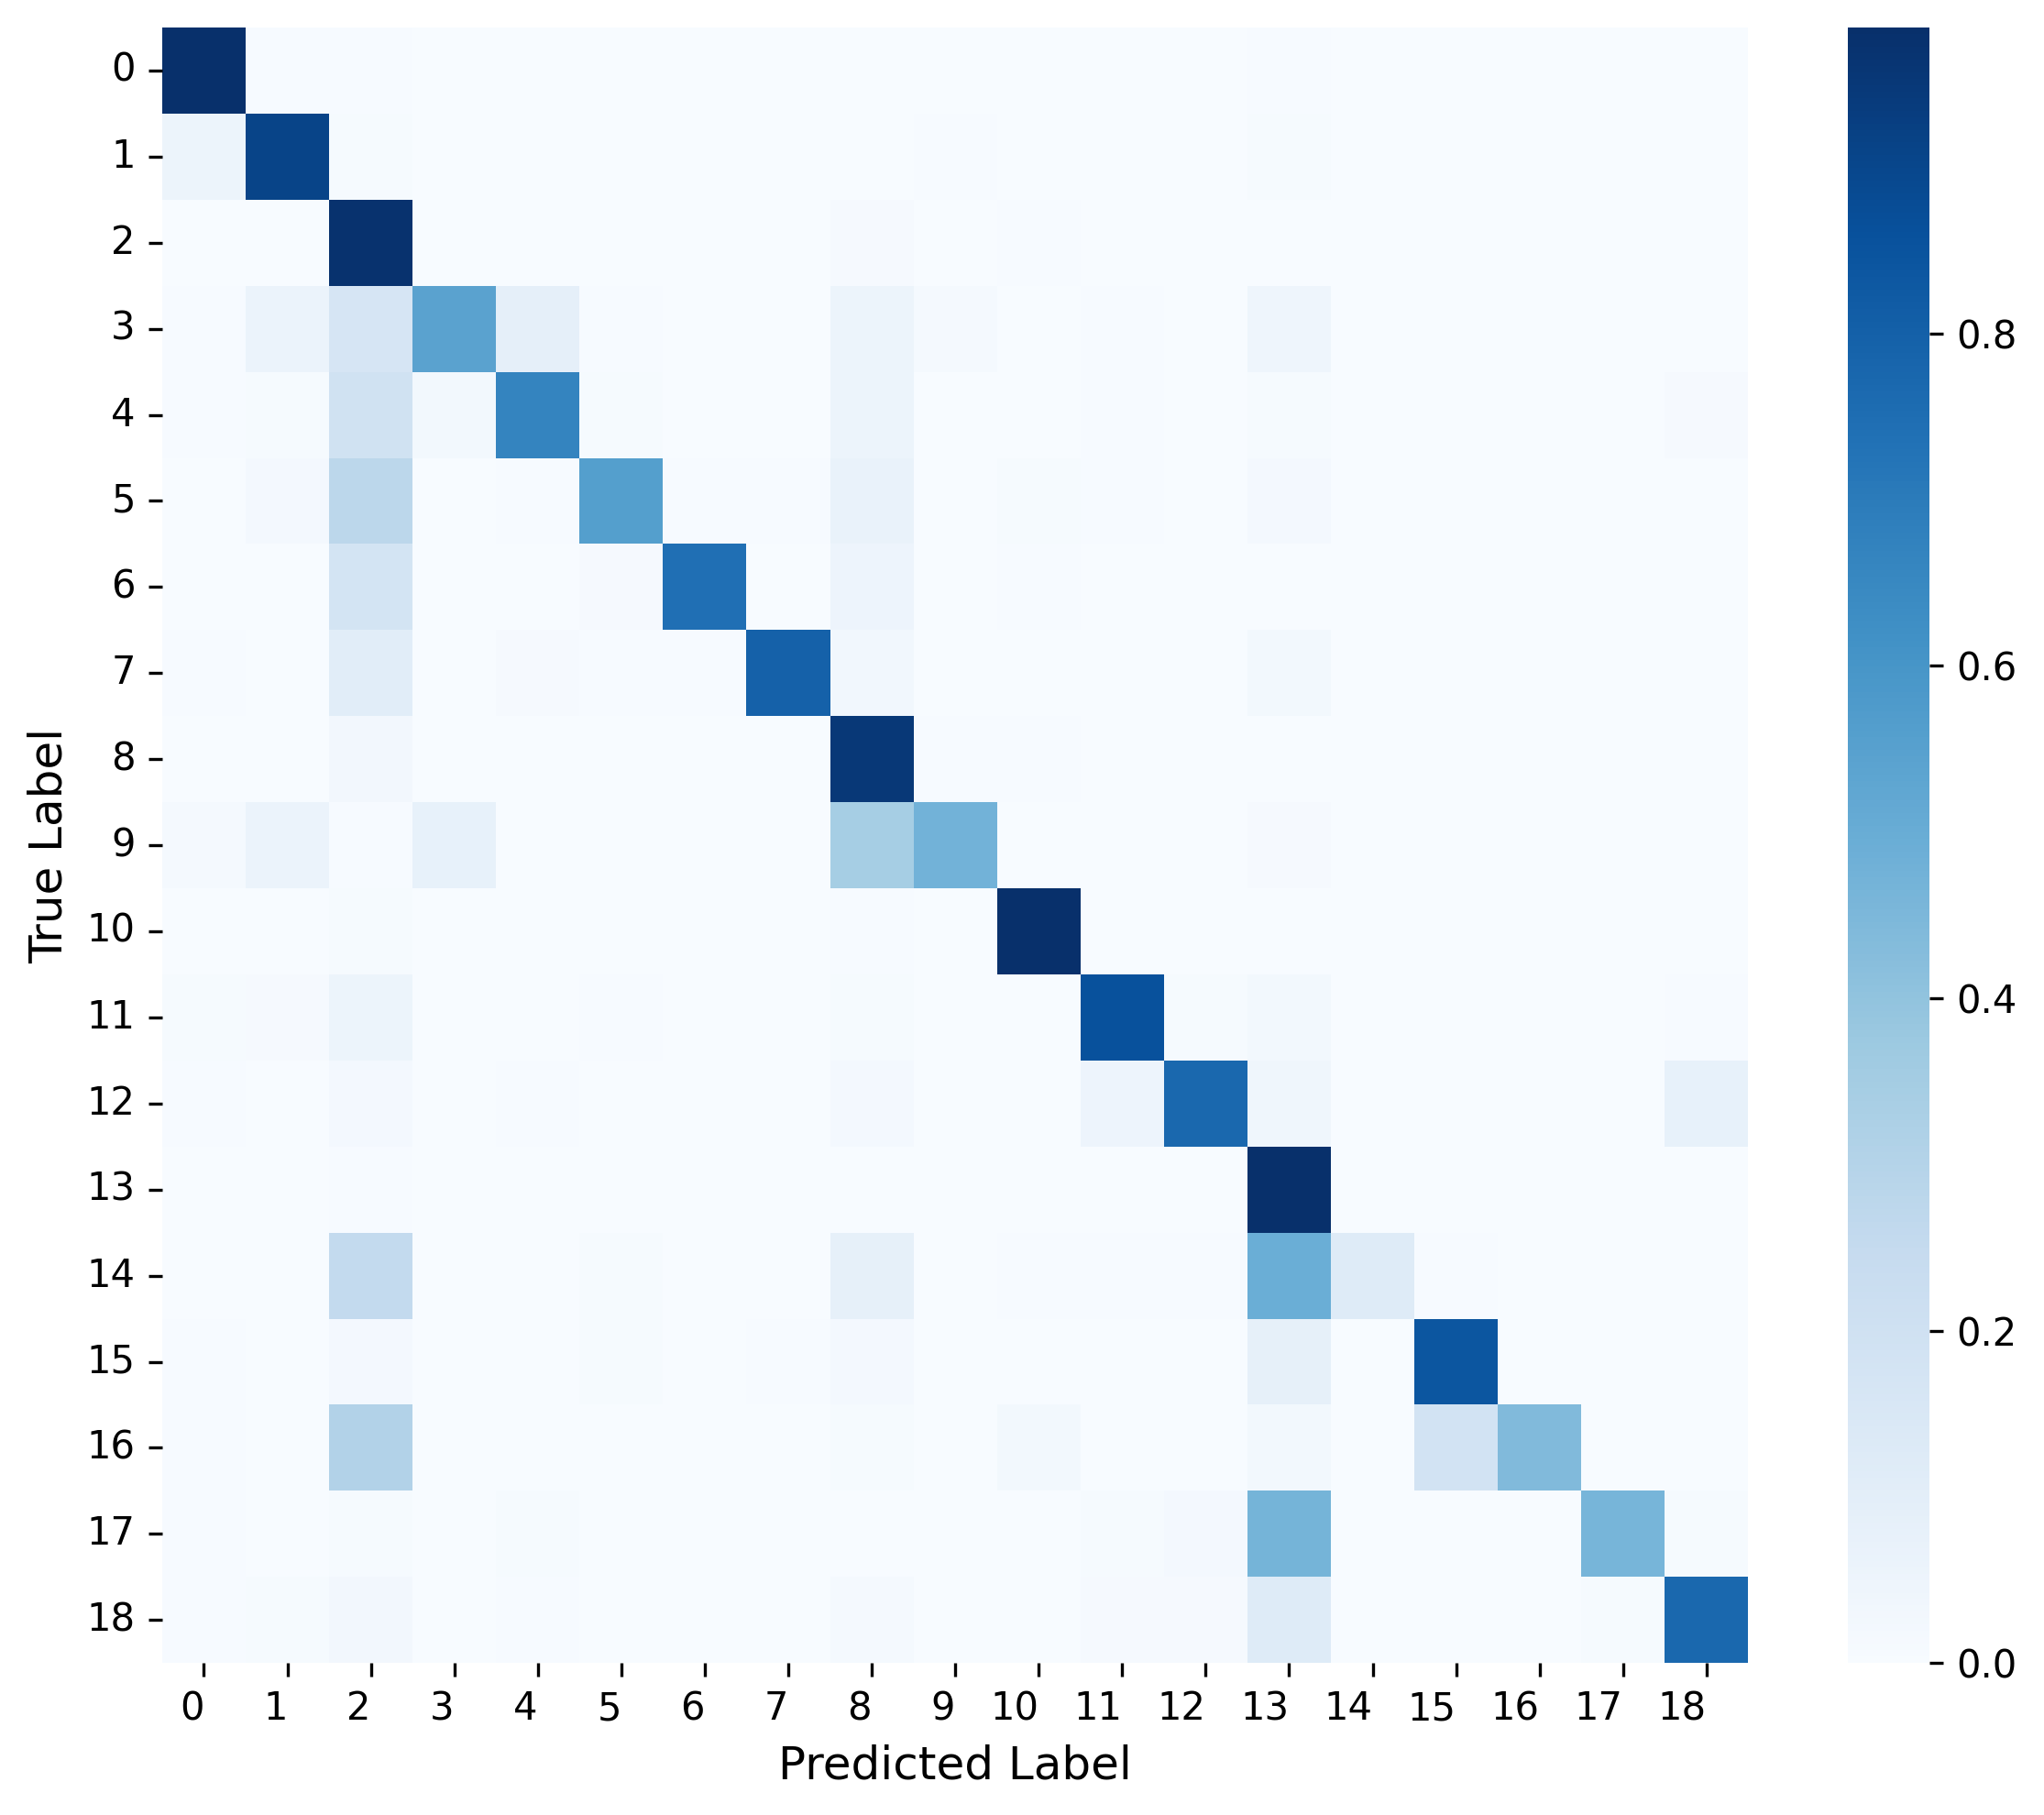

Baseline Metrics:
Overall Acc: 0.9546342353603925
Mean Acc: 0.7868794475720655
FreqW Acc: 0.9170734585565165
Mean IoU: 0.7038970456989521
Class IoU: {0: 0.9798467662083038, 1: 0.8618300081266197, 2: 0.9129407791772995, 3: 0.4657455406343116, 4: 0.6342950332158189, 5: 0.6074757561656057, 6: 0.7062350066538189, 7: 0.7792650219170133, 8: 0.9223914965357018, 9: 0.3563196752053681, 10: 0.9309581908082571, 11: 0.8127434855967166, 12: 0.6063479308959422, 13: 0.9362416626460763, 14: 0.1972428168747187, 15: 0.6474013548273532, 16: 0.5922864280830209, 17: 0.6620808072243185, 18: 0.7623961074838257}
Precision: 0.8473771402866656
Recall: 0.7868794475720652
F1-Score: 0.8068789868464696

Fine-tuned Metrics:
Overall Acc: 0.9443766872210768
Mean Acc: 0.7282353664087517
FreqW Acc: 0.8984506911366421
Mean IoU: 0.6562388371873321
Class IoU: {0: 0.969988068098727, 1: 0.8464086480069447, 2: 0.8883246202915472, 3: 0.4681761514406502, 4: 0.5862505333244326, 5: 0.5173952817376309, 6: 0.6651565940616277, 7: 0.

13it [00:20,  1.56s/it]
c:\09_Master_Program\Uni_Freiburg\Summer_2024\01_DL_lab\Project\Cityscapes\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:69: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
c:\09_Master_Program\Uni_Freiburg\Summer_2024\01_DL_lab\Project\Cityscapes\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:115: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


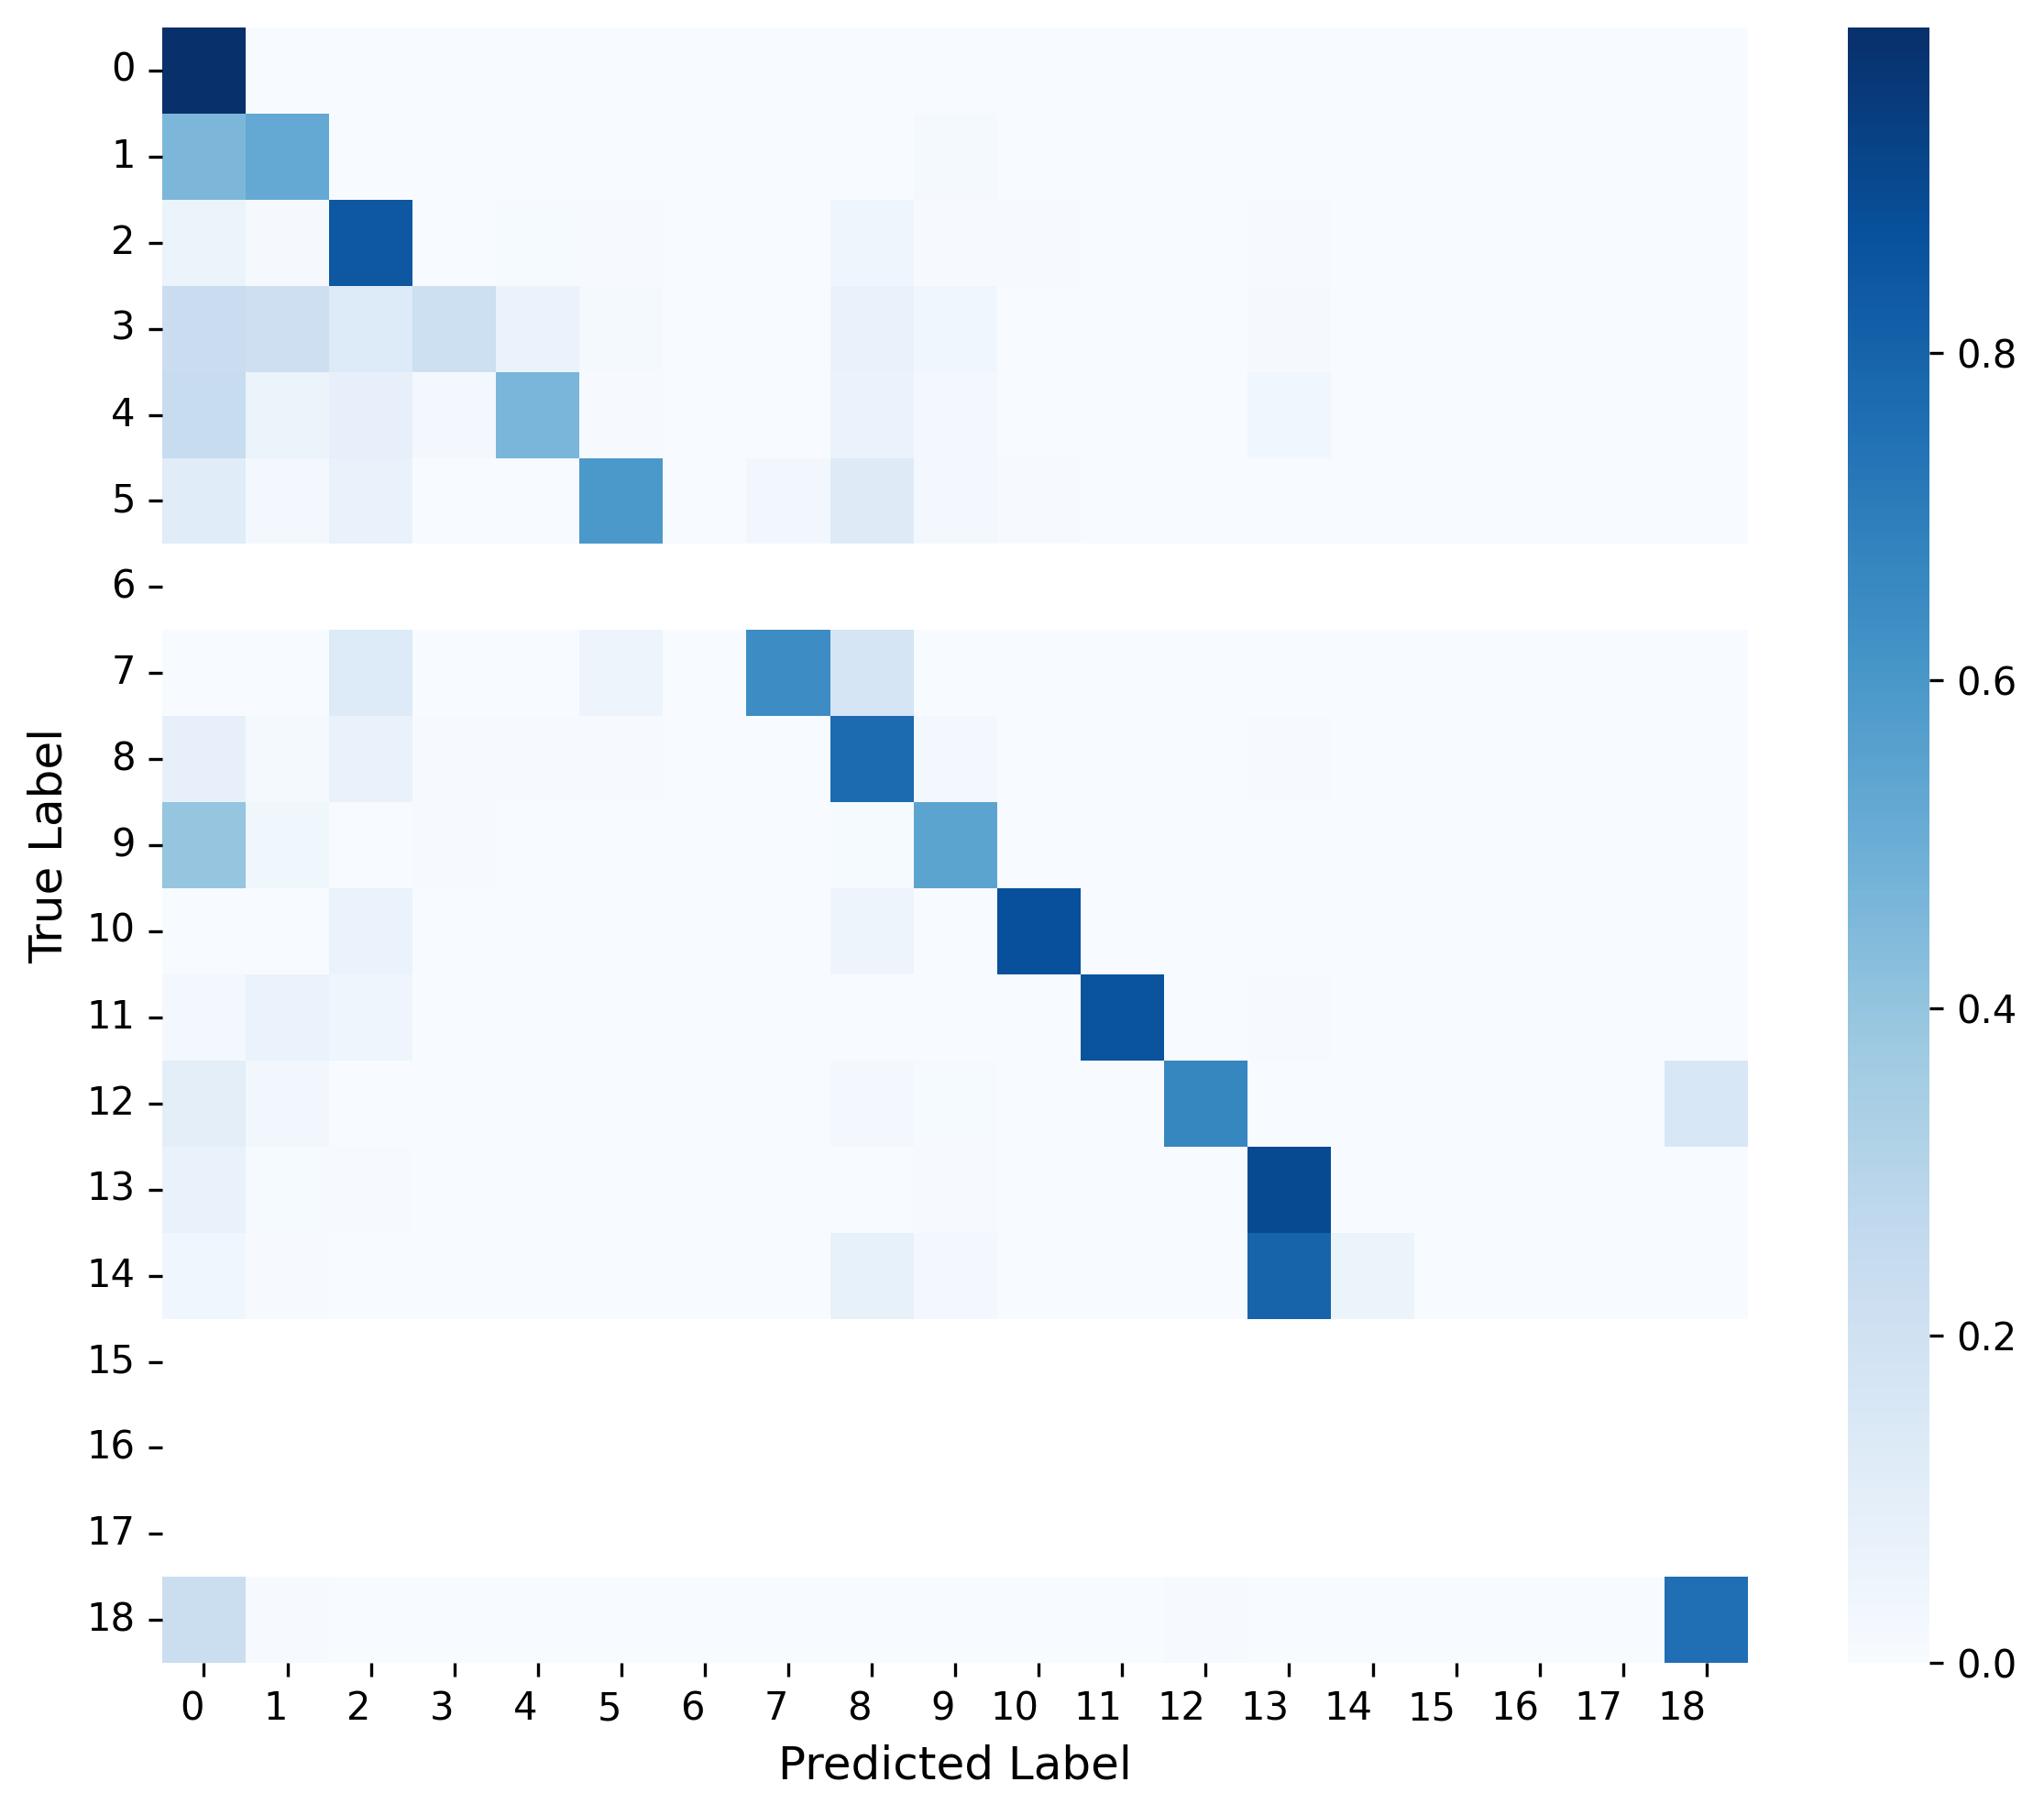

13it [00:19,  1.49s/it]
c:\09_Master_Program\Uni_Freiburg\Summer_2024\01_DL_lab\Project\Cityscapes\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:69: RuntimeWarning: invalid value encountered in divide
  acc_cls = np.diag(hist) / hist.sum(axis=1)
c:\09_Master_Program\Uni_Freiburg\Summer_2024\01_DL_lab\Project\Cityscapes\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:71: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
c:\09_Master_Program\Uni_Freiburg\Summer_2024\01_DL_lab\Project\Cityscapes\DeeplabV3_Cityscapes\src\metrics\stream_metrics.py:115: RuntimeWarning: invalid value encountered in divide
  cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


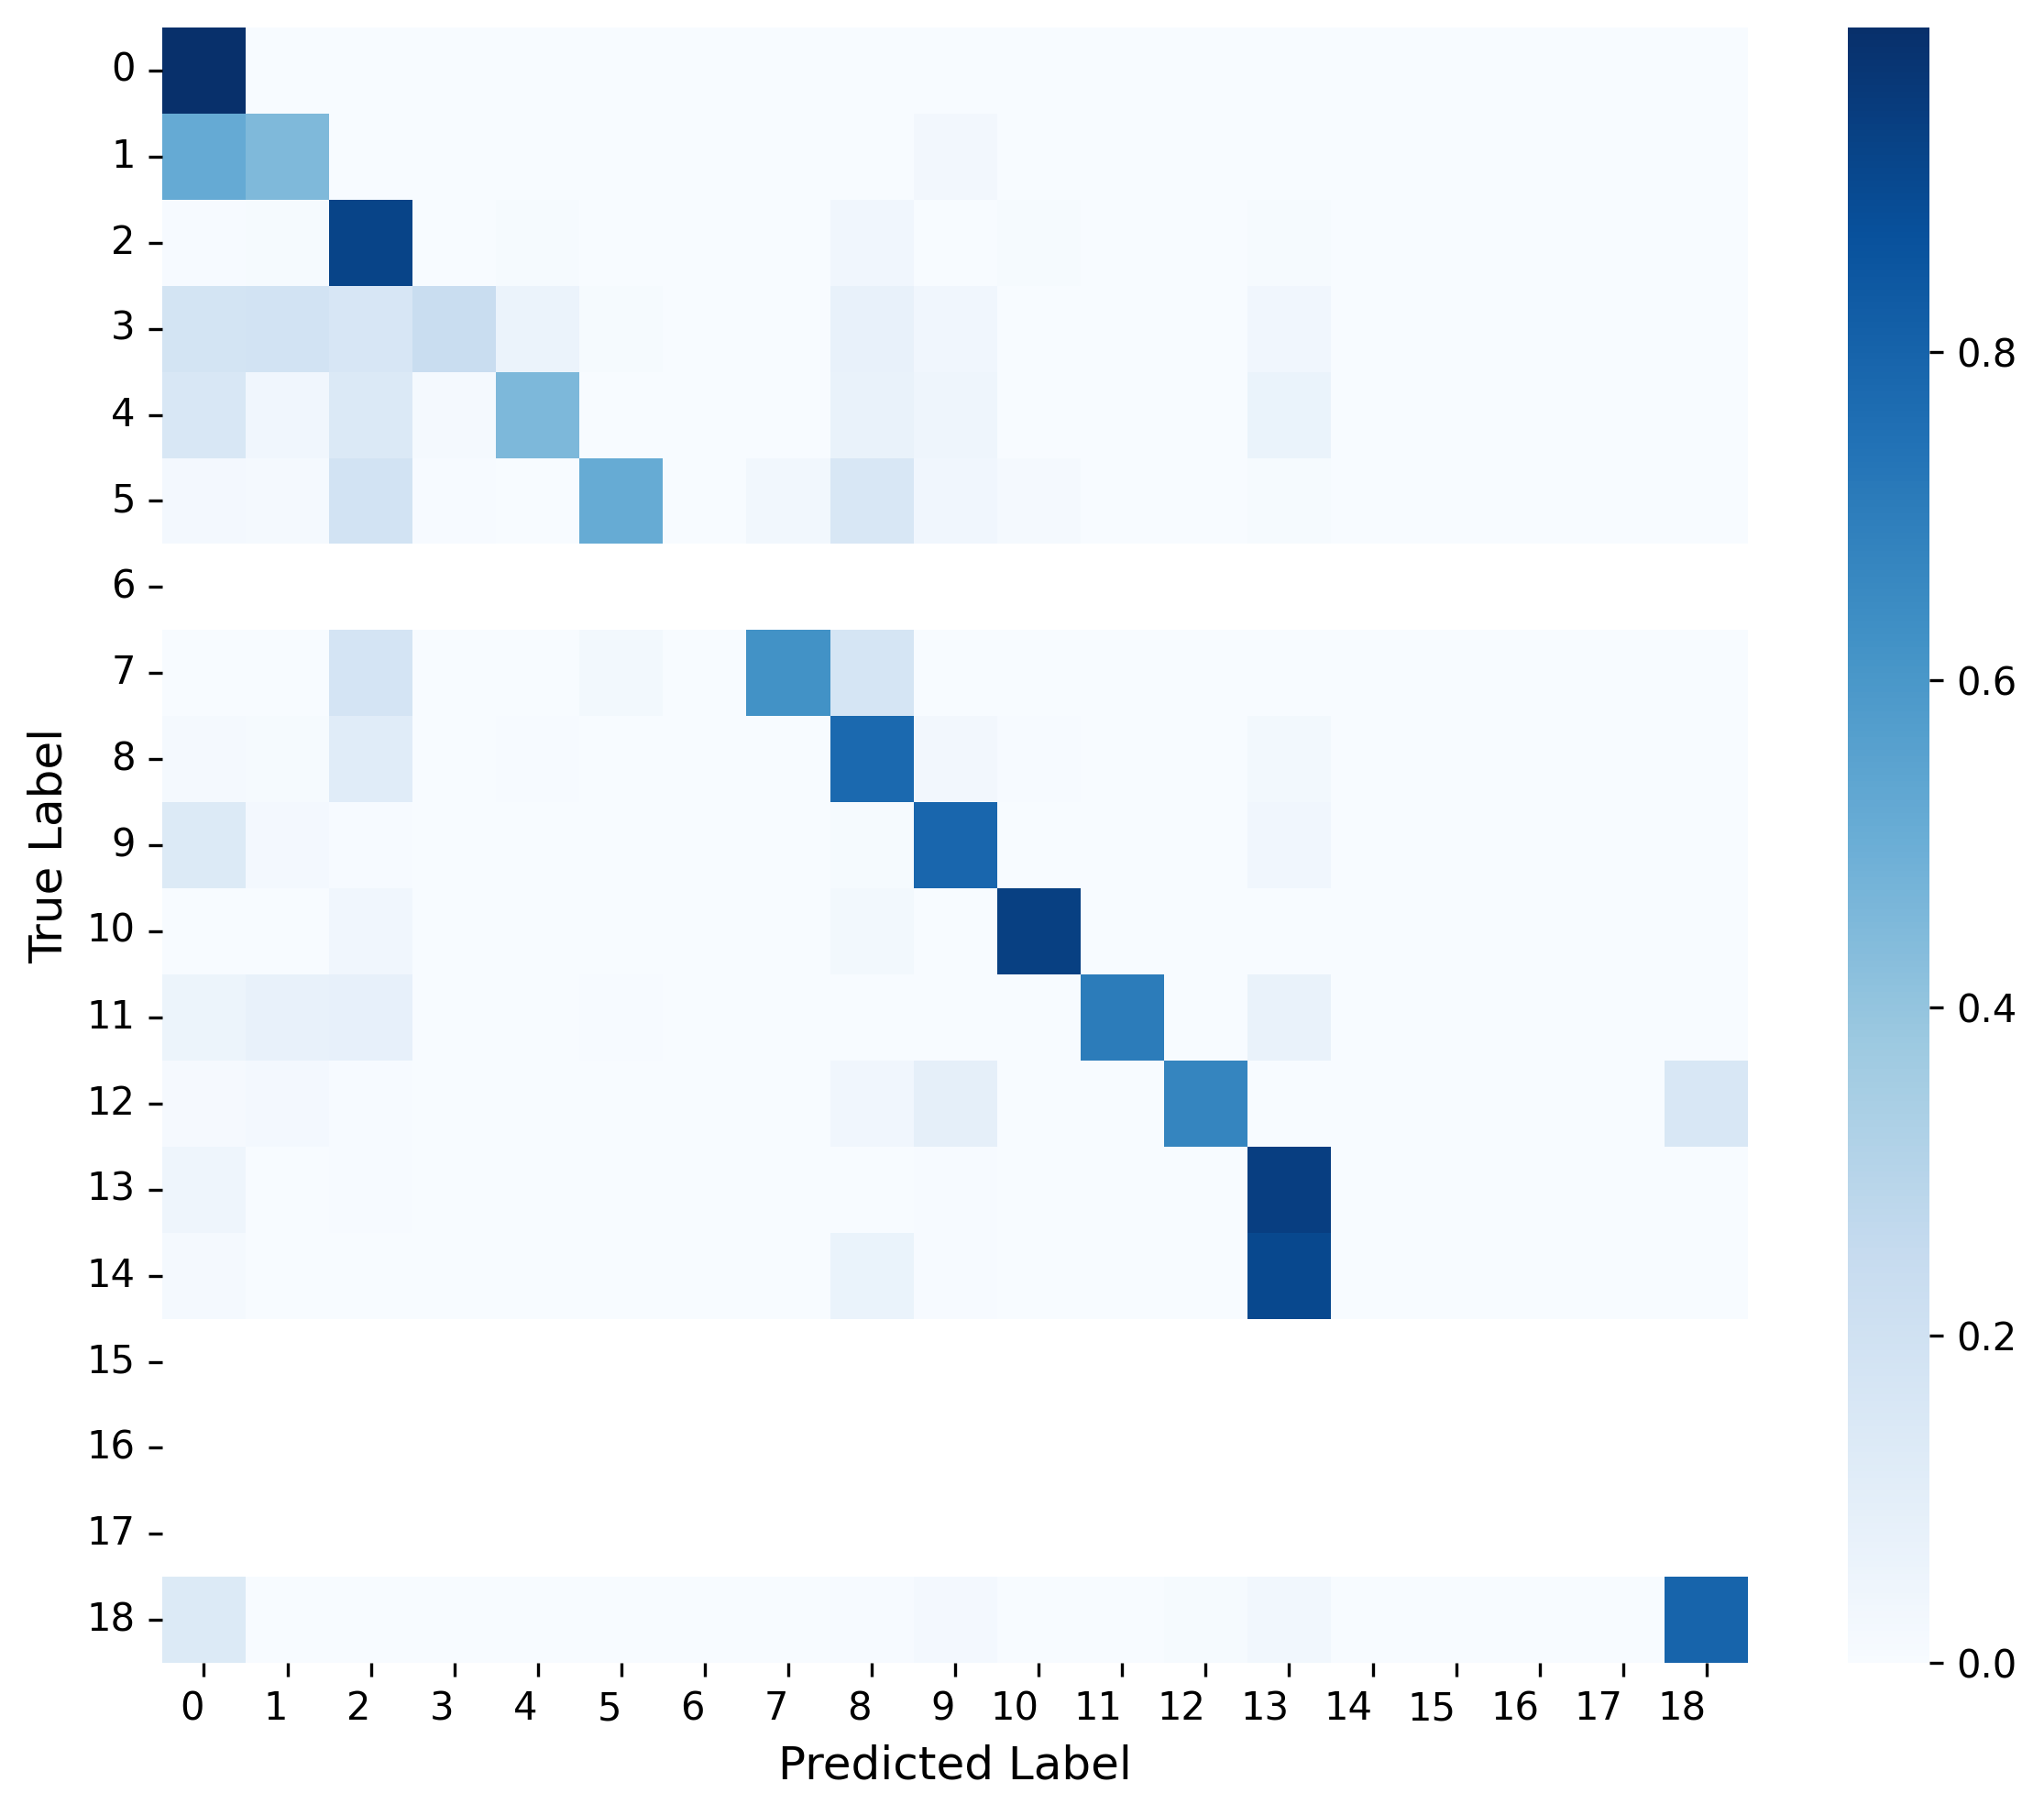

Baseline Metrics:
Overall Acc: 0.7767769714112902
Mean Acc: 0.6473689234012793
FreqW Acc: 0.653972376767346
Mean IoU: 0.3672456858056713
Class IoU: {0: 0.5276634988902241, 1: 0.3369378206424981, 2: 0.7295622279769421, 3: 0.1938289946554751, 4: 0.361182330225328, 5: 0.2657836994739207, 6: 0.0, 7: 0.1445877295818679, 8: 0.733775984857404, 9: 0.49021269810162965, 10: 0.8330759857080692, 11: 0.3010035472819331, 12: 0.6448330369492196, 13: 0.8415178740818351, 14: 0.02944427695708974, 15: 0.0, 16: 0.0, 17: 0.0, 18: 0.5442583249243189}
Precision: 0.48838984170606037
Recall: 0.5110807290010085
F1-Score: 0.4685586044483711

Fine-tuned Metrics:
Overall Acc: 0.8224573723290528
Mean Acc: 0.6548736298969666
FreqW Acc: 0.7017657246493125
Mean IoU: 0.46141032788068714
Class IoU: {0: 0.7080611962961638, 1: 0.333608616179644, 2: 0.7499399978094556, 3: 0.2234514355604958, 4: 0.3564390585350513, 5: 0.3368685696604007, 6: 0.0, 7: 0.24704709311244055, 8: 0.7452257427363151, 9: 0.6904279306075624, 10: 0.865

In [10]:
for dataset_name, json_file in datasets:
    print(f"\nAnalyzing {dataset_name.upper()} dataset:")
    
    # Load data
    val_loader, _, _ = load_data(json_file, dataset_name)
    
    # Validate models
    baseline_results, baseline_preds, baseline_targets = validate(baseline_model, val_loader, device, metrics)
    fig = metrics.plot_confusion_matrix()
    # Display the plot in Jupyter
    display(fig)
    # Save the figure
    fig.savefig('confusion_matrix_model1.png', bbox_inches='tight', dpi=300)
    # Close the figure to free up memory
    plt.close(fig)



    baseline_additional = metrics.get_precision_recall_f1()
    
    finetuned_results, finetuned_preds, finetuned_targets = validate(finetuned_model, val_loader, device, metrics)
    # metrics.plot_confusion_matrix()
    fig = metrics.plot_confusion_matrix()
    # Display the plot in Jupyter
    display(fig)
    # Save the figure
    #fig.savefig('confusion_matrix_model2.png', bbox_inches='tight', dpi=300)
    # Close the figure to free up memory
    plt.close(fig)
    
    finetuned_additional = metrics.get_precision_recall_f1()
    
    # Combine all metrics
    baseline_metrics = {**baseline_results, **baseline_additional}
    finetuned_metrics = {**finetuned_results, **finetuned_additional}
    
    # Print metrics
    print("Baseline Metrics:")
    for k, v in baseline_metrics.items():
        if k != 'Confusion Matrix':
            print(f"{k}: {v}")
    
    print("\nFine-tuned Metrics:")
    for k, v in finetuned_metrics.items():
        if k != 'Confusion Matrix':
            print(f"{k}: {v}")

In [12]:
def plot_iou_comparison(baseline_iou, finetuned_iou, class_names, dataset_name):
    plt.figure(figsize=(15, 8))
    x = np.arange(len(class_names))
    width = 0.35

    baseline_values = [baseline_iou[i] for i in range(len(class_names))]
    finetuned_values = [finetuned_iou[i] for i in range(len(class_names))]

    plt.bar(x - width/2, baseline_values, width, label='Baseline', alpha=0.8)
    plt.bar(x + width/2, finetuned_values, width, label='Fine-tuned', alpha=0.8)

    plt.xlabel('Classes')
    plt.ylabel('IoU')
    plt.title(f'Class-wise IoU Comparison - {dataset_name}')
    plt.xticks(x, class_names, rotation=90)
    plt.legend()

    # Add value labels on top of each bar
    for i, v in enumerate(baseline_values):
        plt.text(i - width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)
    for i, v in enumerate(finetuned_values):
        plt.text(i + width/2, v, f'{v:.2f}', ha='center', va='bottom', rotation=90)

    plt.tight_layout()
    plt.show()

    
def save_segmentation_maps(model, image_paths, output_dir, device, num_images=5):
    os.makedirs(output_dir, exist_ok=True)
    sampled_indices = random.sample(range(len(image_paths)), num_images)
    model.eval()
    with torch.no_grad():
        for idx in sampled_indices:
            image_path = image_paths[idx]
            image = Image.open(image_path).convert('RGB')
            image_tensor = torch.from_numpy(np.array(image)).float().permute(2, 0, 1).unsqueeze(0).to(device)
            output = model(image_tensor).max(1)[1].cpu().numpy()[0]
            segmentation_map = Image.fromarray(output.astype(np.uint8))

            base_name = os.path.basename(image_path).split('.')[0]
            image.save(os.path.join(output_dir, f'{base_name}_original.png'))
            segmentation_map.save(os.path.join(output_dir, f'{base_name}_segmentation.png'))

posx and posy should be finite values
posx and posy should be finite values


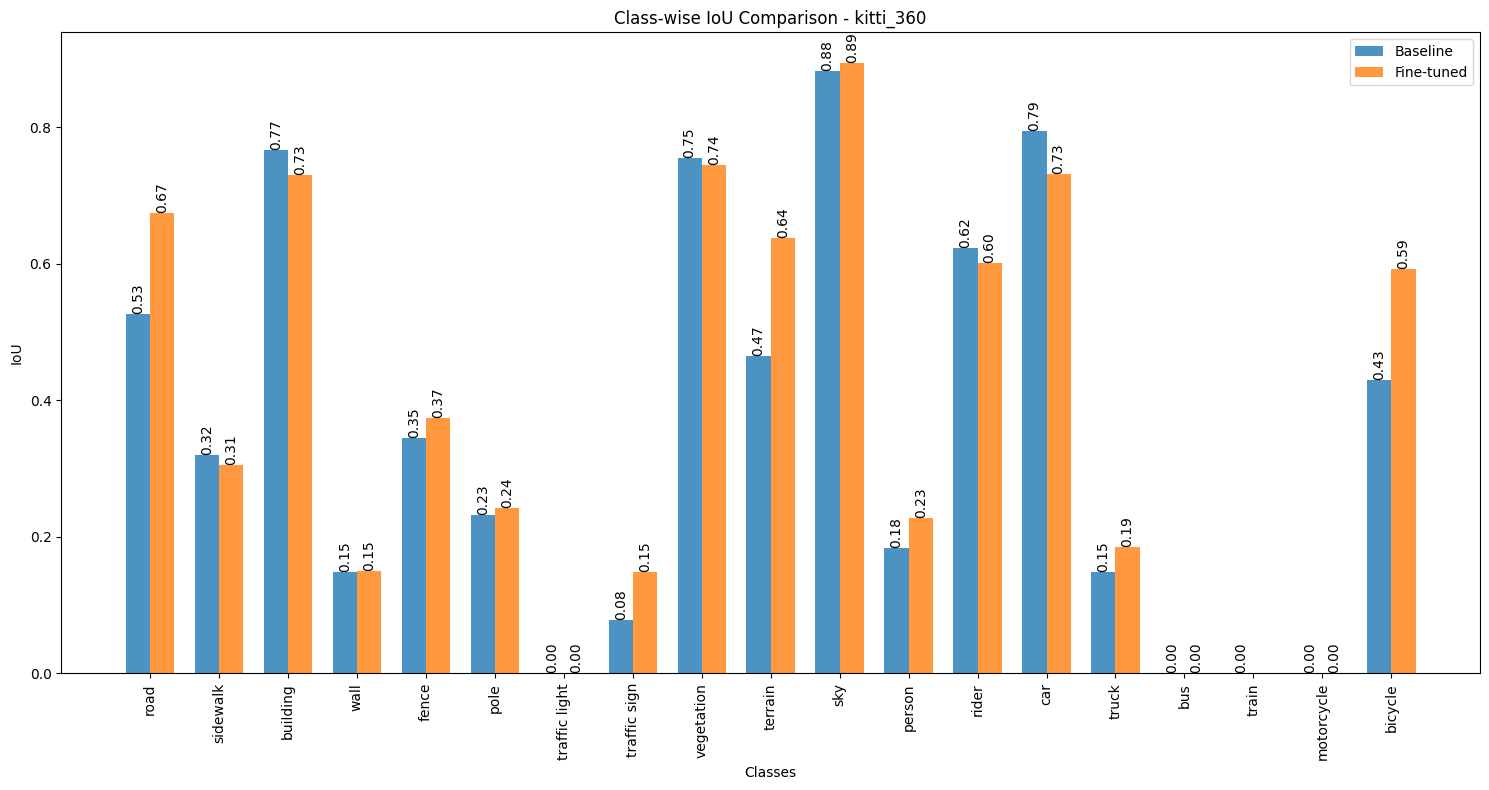


Metrics Comparison for KITTI_360:
        Metric  Baseline  Fine-tuned
          mIoU  0.352444    0.402101
Pixel Accuracy  0.778420    0.805960
 Mean Accuracy  0.615668    0.615090
         FWIoU  0.657598    0.679512
     Precision  0.494332    0.536112
        Recall  0.486053    0.485598
      F1-Score  0.452104    0.482626


In [14]:
   # Plot IoU comparison
baseline_iou = [baseline_metrics['Class IoU'][i] for i in range(len(class_names))]
finetuned_iou = [finetuned_metrics['Class IoU'][i] for i in range(len(class_names))]

plot_iou_comparison(baseline_iou, finetuned_iou, class_names, dataset_name)
    

#Save segmentation maps
#save_segmentation_maps(baseline_model, val_image_paths, f'segmentation_maps/{dataset_name}/baseline', device)
#save_segmentation_maps(finetuned_model, val_image_paths, f'segmentation_maps/{dataset_name}/finetuned', device)
    
# Create a comparison table
comparison_data = {
    'Metric': ['mIoU', 'Pixel Accuracy', 'Mean Accuracy', 'FWIoU', 'Precision', 'Recall', 'F1-Score'],
    'Baseline': [
        baseline_metrics['Mean IoU'],
        baseline_metrics['Overall Acc'],
        baseline_metrics['Mean Acc'],
        baseline_metrics['FreqW Acc'],
        baseline_metrics['Precision'],
        baseline_metrics['Recall'],
        baseline_metrics['F1-Score']
        ],
    'Fine-tuned': [
        finetuned_metrics['Mean IoU'],
        finetuned_metrics['Overall Acc'],
        finetuned_metrics['Mean Acc'],
        finetuned_metrics['FreqW Acc'],
        finetuned_metrics['Precision'],
        finetuned_metrics['Recall'],
        finetuned_metrics['F1-Score']
        ]
   }

df = pd.DataFrame(comparison_data)
print(f"\nMetrics Comparison for {dataset_name.upper()}:")
print(df.to_string(index=False))
